# Monte Carlo Methods

In this notebook, we write an implementation of many Monte Carlo (MC) algorithms. 

### Exploring BlackjackEnv

We begin by importing the necessary packages.

In [2]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

We first create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [3]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

In [6]:
for i_episode in range(5):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(9, 10, False)
End game! Reward:  -1.0
You lost :(

(10, 10, False)
(20, 10, False)
End game! Reward:  -1
You lost :(

(15, 2, False)
End game! Reward:  -1.0
You lost :(

(12, 3, False)
(13, 3, False)
End game! Reward:  -1.0
You lost :(

(18, 3, True)
End game! Reward:  1.0
You won :)



### MC Prediction

In this section, we write an implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [7]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8] # stochastic policy description
        action = np.random.choice(np.arange(2), p=probs) # choose action depending on state
        next_state, reward, done, info = bj_env.step(action) # realize a step based on an action (bj_env knows current state)
        episode.append((state, action, reward)) # logging information
        state = next_state # update state var to update probs var
        if done:
            break
    return episode

Let's play Blackjack with the policy. 

In [9]:
for i in range(15):
    print(generate_episode_from_limit_stochastic(env))

[((4, 4, False), 1, 0), ((7, 4, False), 1, 0), ((17, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[((14, 6, False), 1, -1)]
[((18, 10, False), 1, -1)]
[((18, 1, False), 0, -1.0)]
[((15, 3, False), 1, -1)]
[((12, 6, False), 1, 0), ((18, 6, False), 1, 0), ((20, 6, False), 0, 1.0)]
[((13, 7, False), 1, 0), ((14, 7, False), 0, -1.0)]
[((5, 10, False), 1, 0), ((7, 10, False), 1, 0), ((17, 10, False), 1, -1)]
[((17, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[((16, 10, False), 1, -1)]
[((13, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[((20, 10, False), 0, 0.0)]
[((15, 6, False), 1, -1)]
[((20, 10, False), 0, 1.0)]
[((14, 6, True), 1, 0), ((12, 6, False), 1, 0), ((21, 6, False), 1, -1)]


Now, we can write our own implementation of MC prediction.  We implement here **first-visit** MC prediction;

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [77]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n)) # stores sum of returns for each [state][action]
    N = defaultdict(lambda: np.zeros(env.action_space.n)) # stores total number of visits for each [state][action] 
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # stores Q values for each [state][action] = returns_sum / N
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # Generate an episode following the env policy : S0, A0, R1, S1, A1, R2,...,ST 1, AT 1, RT
        episode = generate_episode(env)
        episode_seen_states = []
        length_episode = len(episode)

        for i in range(length_episode):
            
            current_state = episode[i][0]
            current_action = episode[i][1]
            current_reward = episode[i][2]
            
            gamma_to_power = [gamma ** k for k in range(length_episode - i)]
            next_rewards = [episode[k][2] for k in range(i, length_episode)]
            
            current_return = np.sum(np.multiply(next_rewards, gamma_to_power))
            
            if current_state not in episode_seen_states:
                
                N[current_state][current_action] += 1
                returns_sum[current_state][current_action] += current_return
                
                episode_seen_states.append(current_state)
    
    for s in N.keys():        
        Q[s] = np.divide(returns_sum[s], N[s])
    return Q

By running the cell below, we obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

Episode 500000/500000.

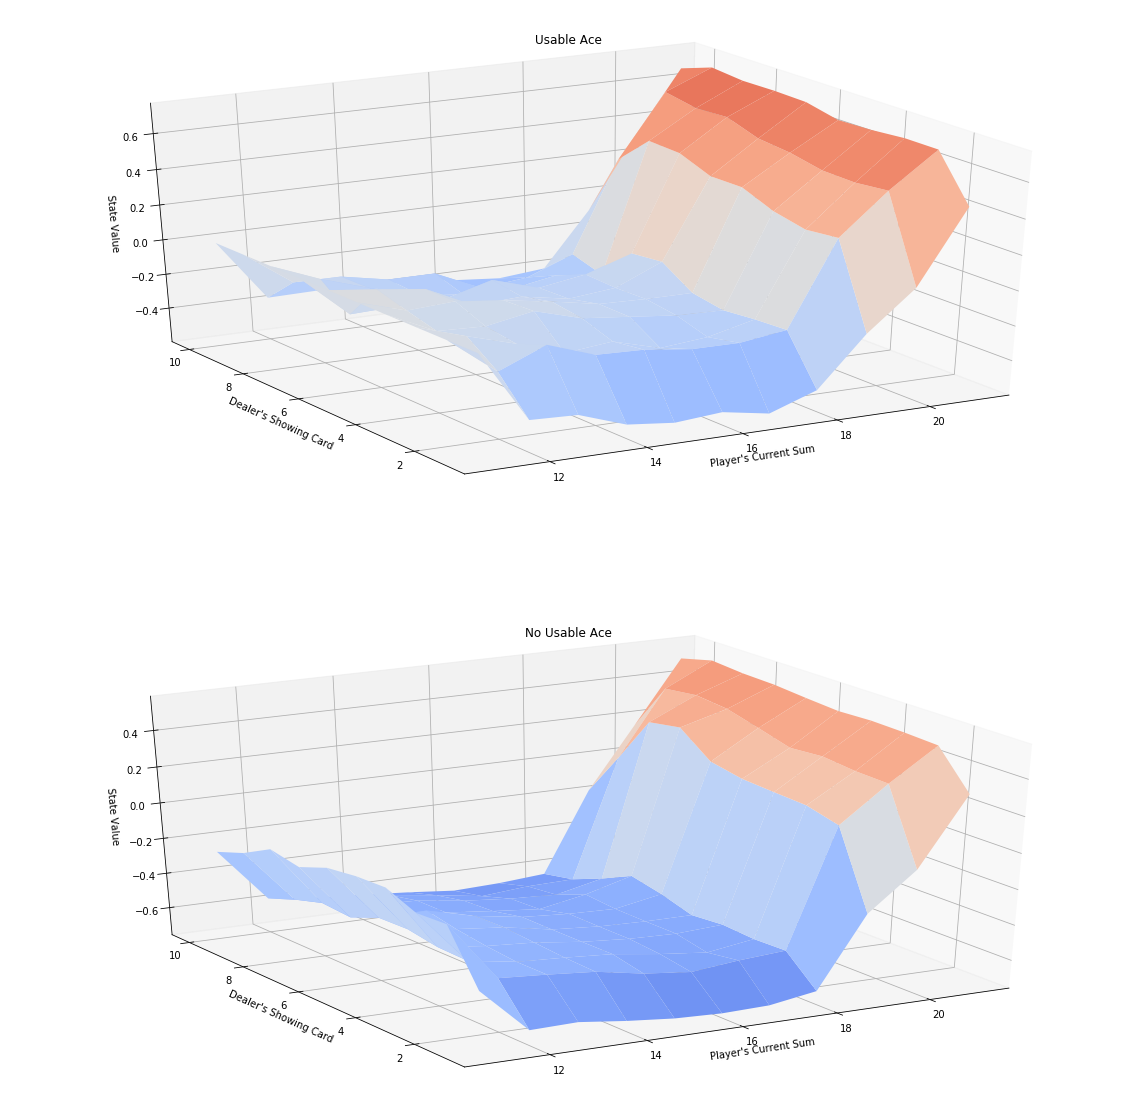

In [79]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### MC Control

In this section, we write your own implementation of constant-$\alpha$ MC control.  

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [ ]:
def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, ?, ?)

Next, we plot the corresponding state-value function.

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)